In [2]:

# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 20})
# CLustering 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import fowlkes_mallows_score
#Optimization
import optuna
# Output control
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
# Json
import json

In [3]:
adata = sc.read("datasets/tumour_cellcounts.h5ad")
padata = sc.read("datasets/processed_pooledcounts.h5ad")

# **Gene set variation analysis for aggresive cancer gene-sets**

First of all we need to find the corresponding gene sets for the EMT, ANGIOGENESIS and STEMNESS pathways. We can discover these from the relevant SOURCES by  [Hallmark](https://pubmed.ncbi.nlm.nih.gov/26771021/), [Lawson et al.](https://www.nature.com/articles/nature15260)

In [4]:
with open('Genesets/Aggresive/HALLMARK_ANGIOGENESIS.v2023.1.Hs.json', 'r') as file:
    angiogenesis_gene_set = json.load(file)
    angiogenesis_gene_set = angiogenesis_gene_set['HALLMARK_ANGIOGENESIS']['geneSymbols']
    
with open('Genesets/Aggresive/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.v2023.1.Hs.json', 'r') as file:
    emt_gene_set = json.load(file)
    emt_gene_set = emt_gene_set['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION']['geneSymbols']
    
with open('Genesets/Aggresive/LAWSON_STEMNESS.json','r') as file:
    stemness_gene_set = json.load(file)
    stemness_gene_set = stemness_gene_set['geneSymbols']

Due to preprocessing some genes are not available in the current dataset form, so we take the intersection of the gene sets with our dataset and report the number of genes removed with this method.

In [78]:
angiogenesis_gene_set_final = set(adata.var_names) & set(angiogenesis_gene_set)
print(f"Genes removed from the gene set: {len(set(angiogenesis_gene_set) - angiogenesis_gene_set_final)} out of {len(angiogenesis_gene_set)}\n")

emt_gene_set_final = set(adata.var_names) & set(emt_gene_set)
print(f"Genes removed from the gene set: {len(set(emt_gene_set) - emt_gene_set_final)} out of {len(emt_gene_set)}\n")

stemness_gene_set_final = set(adata.var_names) & set(stemness_gene_set)
print(f"Genes removed from the gene set: {len(set(stemness_gene_set) - stemness_gene_set_final)} out of {len(stemness_gene_set)}\n")

Genes removed from the gene set: 4 out of 36

Genes removed from the gene set: 8 out of 200

Genes removed from the gene set: 0 out of 34



In [79]:
sc.tl.score_genes(adata,angiogenesis_gene_set_final,score_name = "Angiogenesis score")
sc.tl.score_genes(adata,emt_gene_set_final,score_name = "EMT score")
sc.tl.score_genes(adata,stemness_gene_set_final,score_name = "Stemness score")

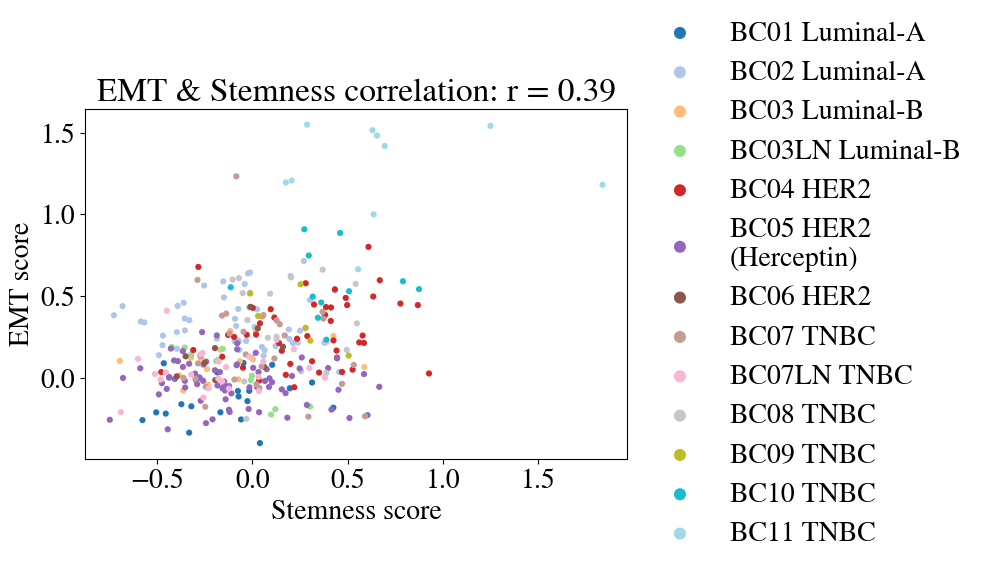

In [80]:
corr = np.corrcoef(x = adata.obs['Stemness score'],y= adata.obs['EMT score'])[1][0]
sc.pl.scatter(adata, x = 'Stemness score', y = "EMT score", color='tumor_groups', size = 80,title=f"EMT & Stemness correlation: r = {round(corr,2)}")

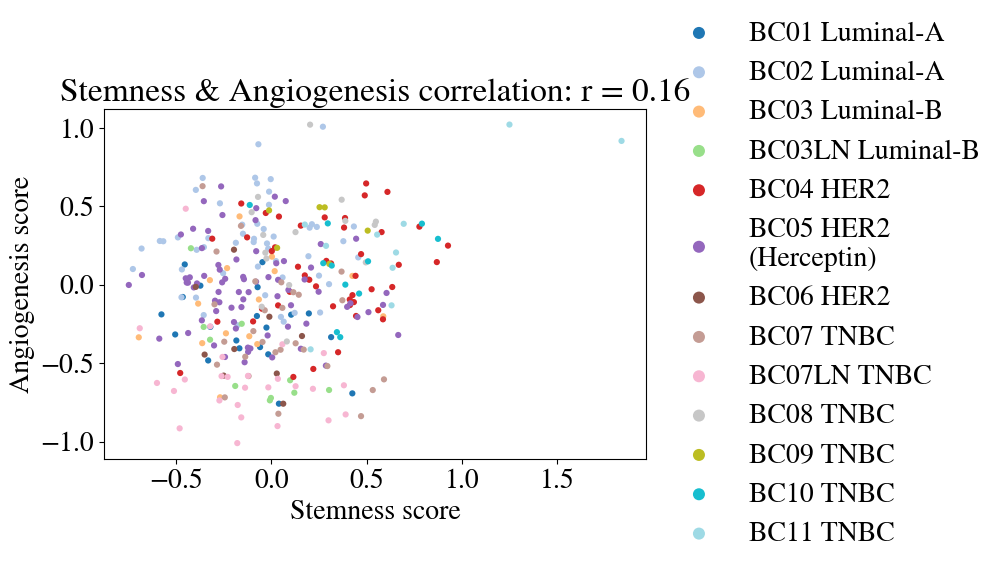

In [81]:
corr = np.corrcoef(x = adata.obs['Stemness score'],y= adata.obs['Angiogenesis score'])[1][0]
sc.pl.scatter(adata, x = 'Stemness score', y = "Angiogenesis score", color='tumor_groups', size = 80,title=f"Stemness & Angiogenesis correlation: r = {round(corr,2)}")

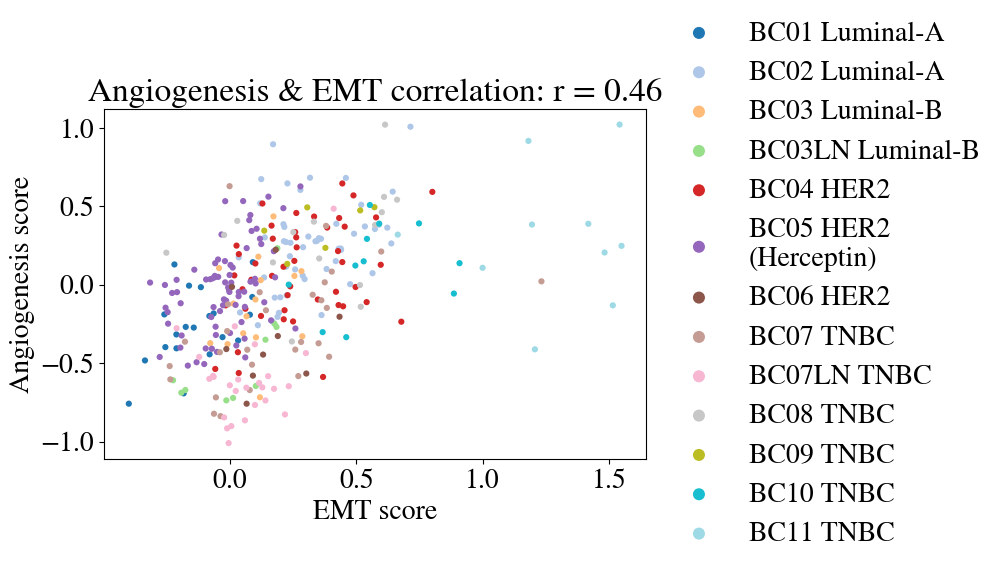

In [82]:
corr = np.corrcoef(x = adata.obs['EMT score'],y= adata.obs['Angiogenesis score'])[1][0]
sc.pl.scatter(adata, x = "EMT score",y = 'Angiogenesis score', color='tumor_groups', size = 80,title=f"Angiogenesis & EMT correlation: r = {round(corr,2)}")


Triple-negative breast cancer (TNBC) cells exhibit relatively elevated epithelial-mesenchymal transition (EMT) signatures, while both HER2 and TNBC tumor cells display increased levels of stemness and angiogenesis signatures. However, it is crucial to acknowledge the heterogeneity present within cancer subtypes.

# **GSVA for Subtype-specific gene expression profiling at single-cell resolution.**

In order to plot correctly the results of the GSVA we define a function that accepts as input the directory of the gene sets and the adata object and returns a dictionary with the gene sets as keys and the corresponding genes as values.

In [83]:
def buildGeneset(directory,adata):
  json_files = [file for file in os.listdir(directory) if file.endswith('.json')]
  gene_sets = {}

  for file in json_files:
      file_name = os.path.splitext(file)[0]  # Remove the file extension
      gene_set_name = file_name.split('.')[0]  # Extract the desired part of the file name
      with open(os.path.join(directory, file), 'r') as f:
          gene_set_data = json.load(f)
          # Extract the nested gene set using the appropriate key
          try:
            gene_set = gene_set_data['genes']
          except KeyError:
            gene_set = gene_set_data[gene_set_name]['geneSymbols']
          gene_set_final = set(adata.var_names) & set(gene_set)
          print(f"Genes removed from the gene set: {len(set(gene_set) - gene_set_final)} out of {len(gene_set)}\n")
          gene_sets[gene_set_name] = gene_set_final
  return gene_sets

The merker genes for ER+, HER2+ and TNBC cancer subtypes are given to us in pdf format from the original paper identified with likelihood ratio test (LRT) based on zero-inflated data. We can grab them and load them into json files.

## *Average expression of the marker genes for each tumor group*

to find the average expression of the marker genes for each tumour group we utilize the `scores_genes` function from scanpy which compares the average expression of the genes in each group with a randomly sampled reference gene set. We can then plot the results in a heatmap for the single cell and the pooled datasets.

Genes removed from the gene set: 0 out of 67

Genes removed from the gene set: 0 out of 48

Genes removed from the gene set: 0 out of 70



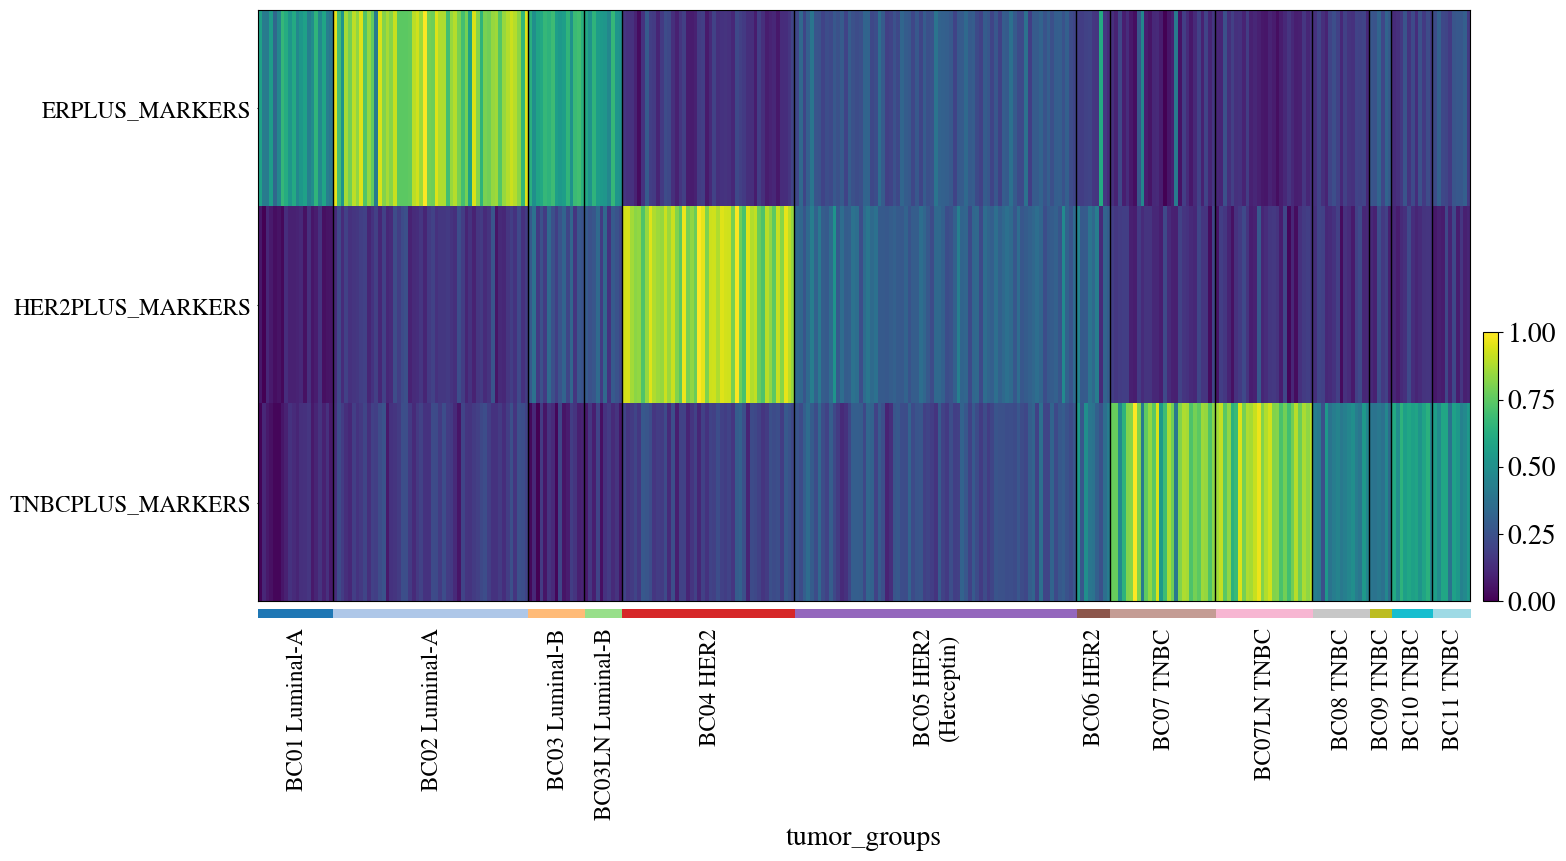

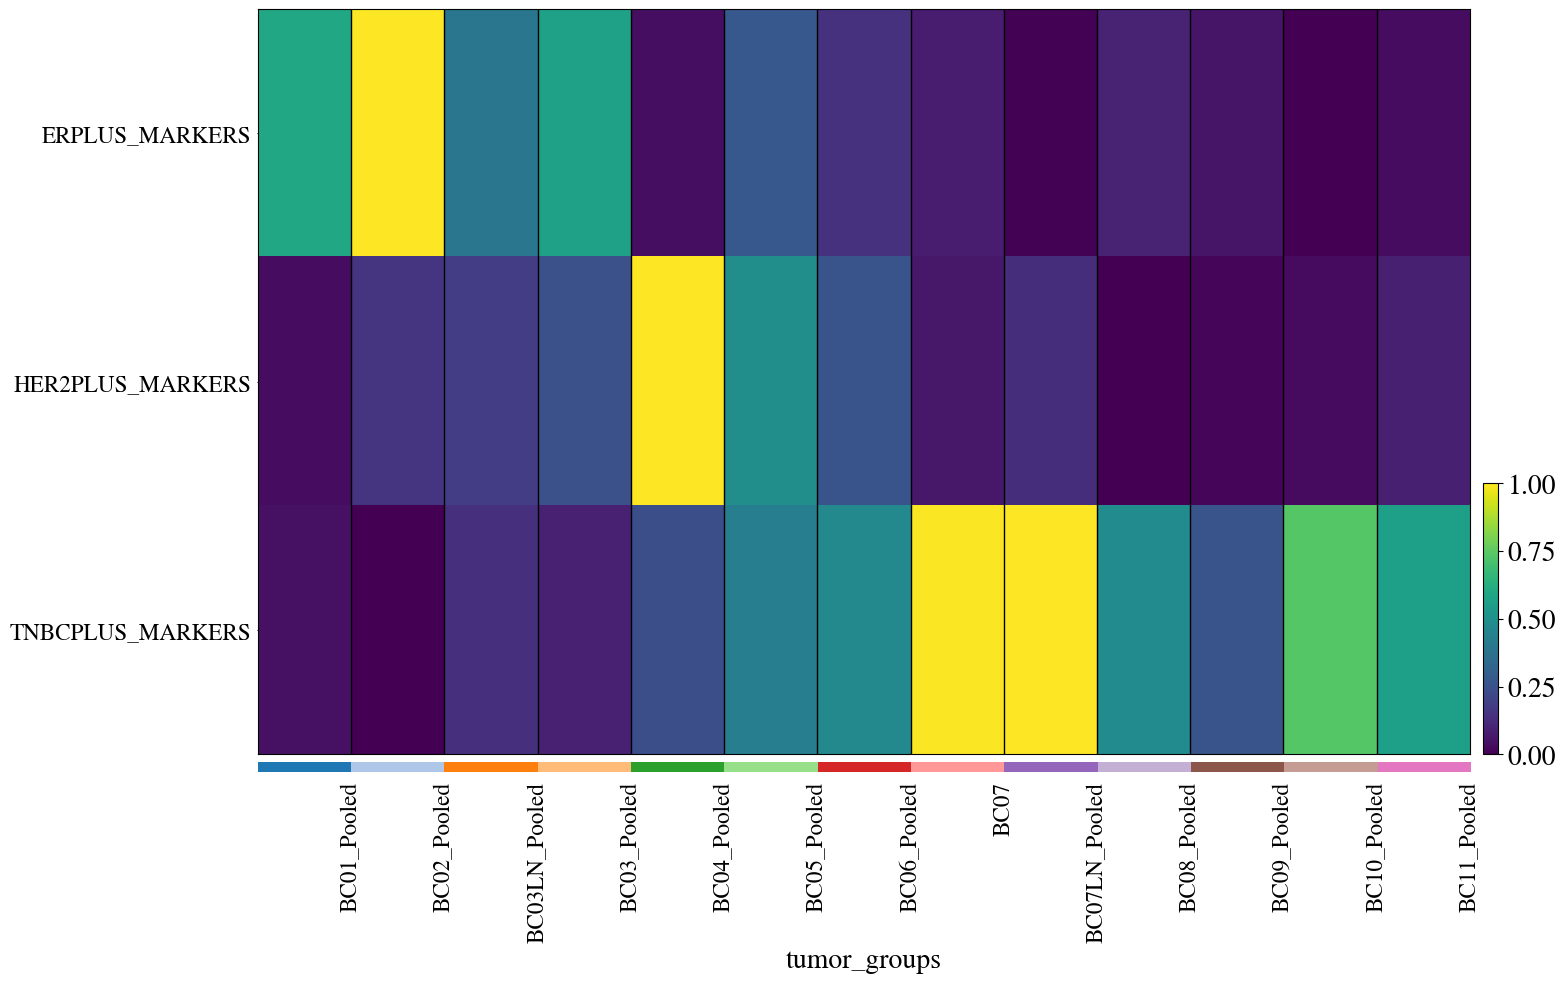

In [84]:
gene_sets = buildGeneset('Genesets/Markers',adata)
for key in gene_sets.keys():
  # For single cell data
  sc.tl.score_genes(adata,gene_sets[key],score_name = key)
  # For pooled data
  sc.tl.score_genes(padata,gene_sets[key],score_name = key)
  
# Plot scingle cell data
sc.pl.heatmap(
    adata,
    var_names=list(gene_sets.keys()),
    groupby="tumor_groups",
    swap_axes=True,
    standard_scale='var',
    vmin=0,
    vmax=1,
    figsize=(16, 8)
)

# Plot pooled data
sc.pl.heatmap(
  padata,
  var_names=list(gene_sets.keys()),
  groupby="tumor_groups",
  swap_axes=True,
  standard_scale='var',
  vmin=0,
  vmax=1,
  figsize=(16, 10)
)

## *Raw expression of the marker genes for each tumor group*

We can also find the raw expression of the marker genes for each cell without taking the average for each group. Again we can plot the results in a heatmap for both the single cell dataset and the pooled dataset. Additionally we utilize a `vmin` value of 0.5 to preserve visual clarity.

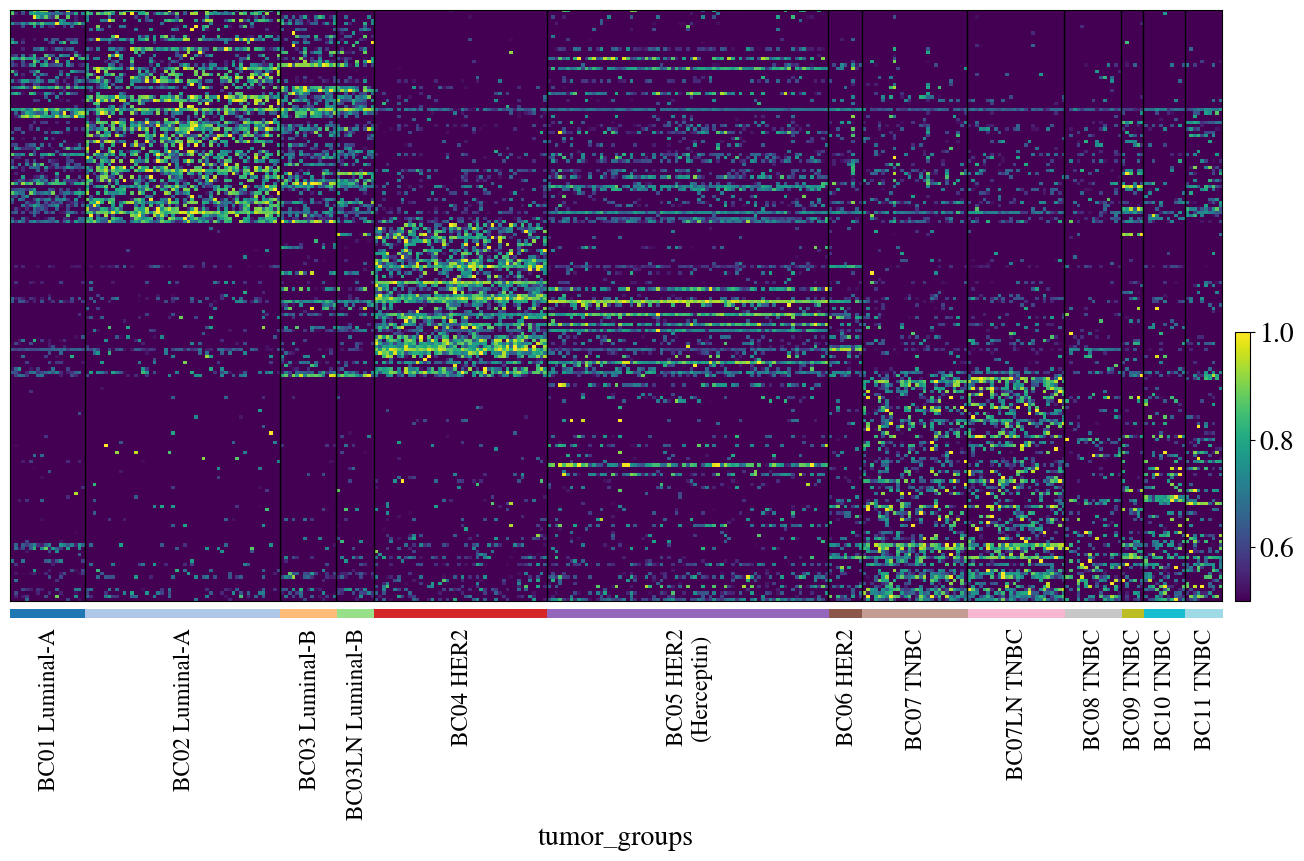

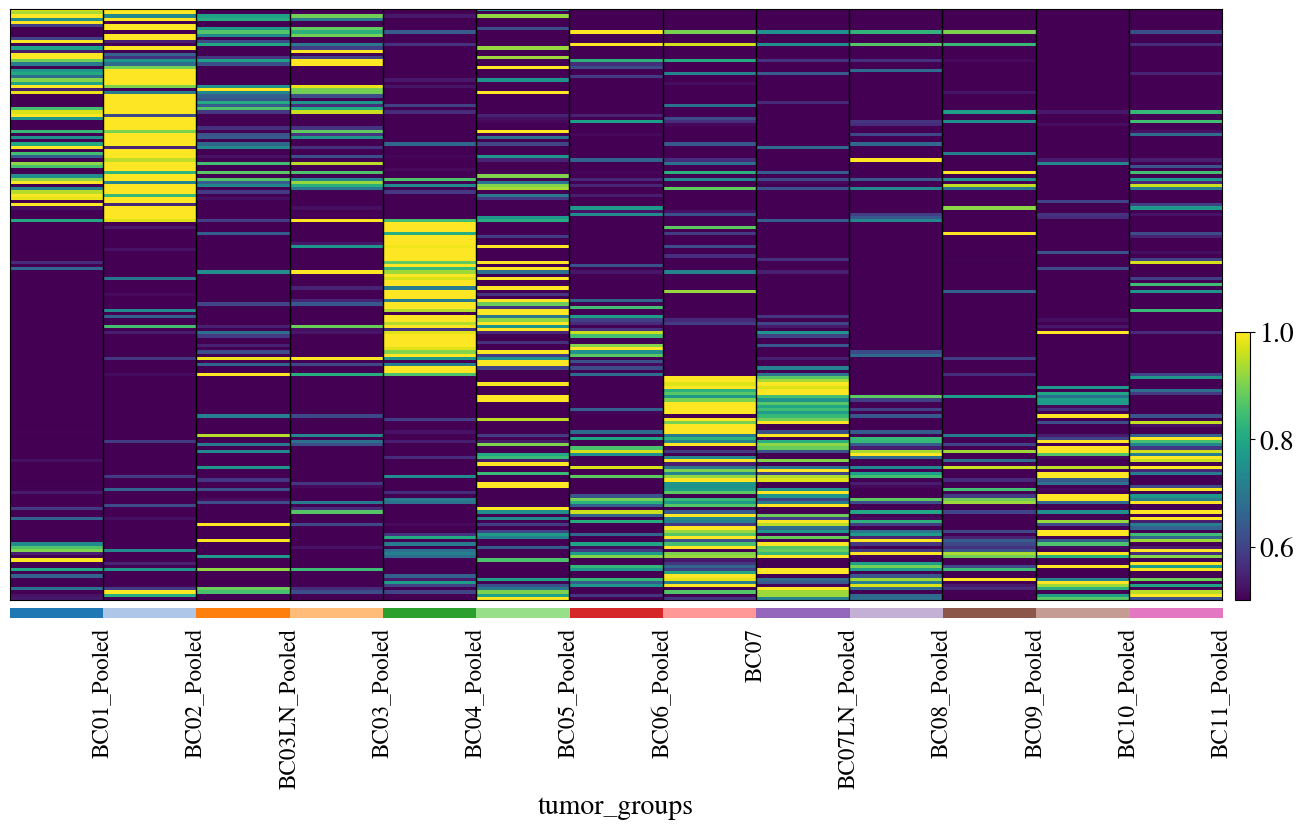

In [88]:
with open('Genesets/Markers/ERPLUS_MARKERS.json', 'r') as file:
    er_marker_genes = json.load(file)
    er_marker_genes = er_marker_genes['genes']
    
with open('Genesets/Markers/HER2PLUS_MARKERS.json', 'r') as file:
    her2_marker_genes = json.load(file)
    her2_marker_genes = her2_marker_genes['genes']
    
with open('Genesets/Markers/TNBCPLUS_MARKERS.json','r') as file:
    tnbc_marker_genes = json.load(file)
    tnbc_marker_genes = tnbc_marker_genes['genes']
    
sc.pl.heatmap(adata, 
              var_names =er_marker_genes + her2_marker_genes + tnbc_marker_genes,
              groupby = "tumor_groups",
              swap_axes=True,
              standard_scale = 'var',
              vmin = 0.5,
              figsize=(16,8)
              )

sc.pl.heatmap(padata, 
              var_names =er_marker_genes + her2_marker_genes + tnbc_marker_genes,
              groupby = "tumor_groups",
              swap_axes=True,
              standard_scale = 'var',
              vmin = 0.5,
              figsize=(16,8)
              )

**Combined marker gene analysis**

# **For Subtype-related pathways**

Genes removed from the gene set: 6 out of 200

Genes removed from the gene set: 6 out of 200

Genes removed from the gene set: 26 out of 132

Genes removed from the gene set: 50 out of 662

Genes removed from the gene set: 16 out of 169

Genes removed from the gene set: 1 out of 41



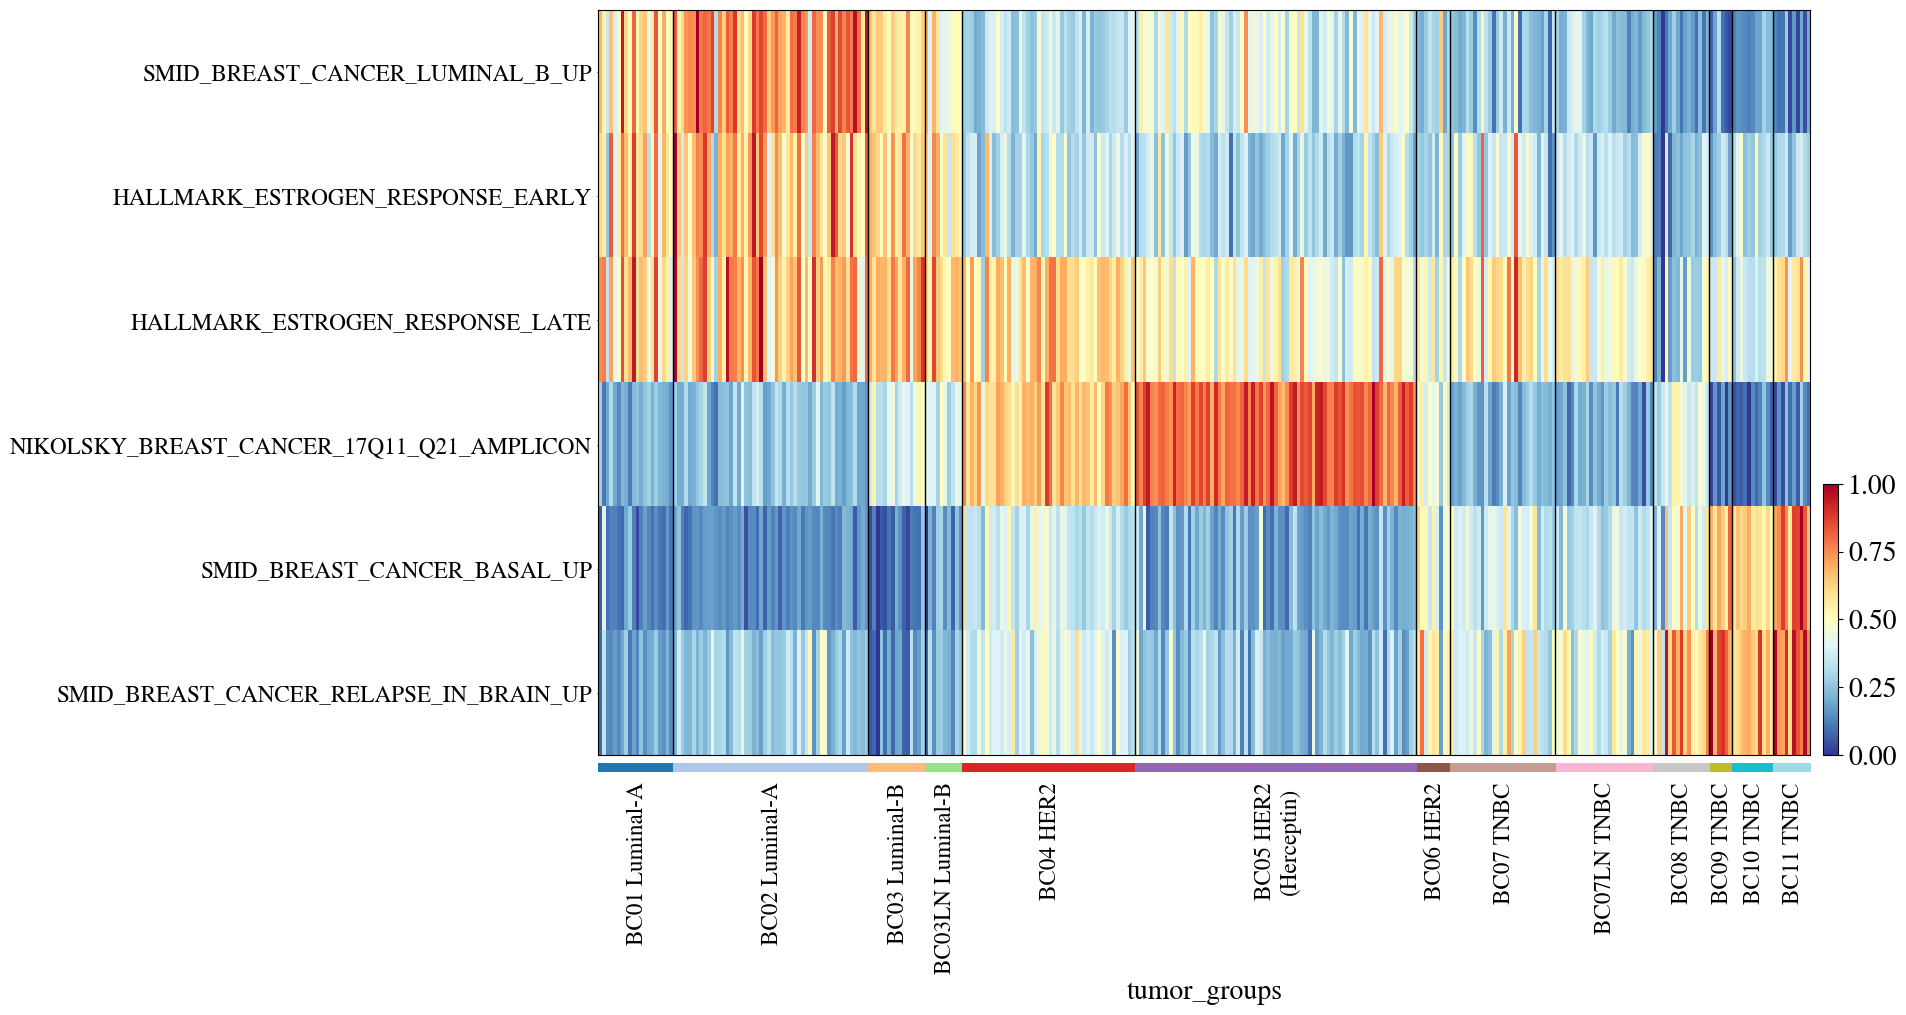

In [86]:
gene_sets = buildGeneset('Genesets/Subtype/',adata)

for key in gene_sets.keys():
  sc.tl.score_genes(adata,gene_sets[key],score_name = key)
  
correct_order = ['SMID_BREAST_CANCER_LUMINAL_B_UP', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE'
                 ,'NIKOLSKY_BREAST_CANCER_17Q11_Q21_AMPLICON',
                 'SMID_BREAST_CANCER_BASAL_UP', 'SMID_BREAST_CANCER_RELAPSE_IN_BRAIN_UP']  

sc.pl.heatmap(
    adata,
    var_names=correct_order,
    groupby="tumor_groups",
    swap_axes=True,
    standard_scale='var',
    vmin=0,
    vmax=1,
    figsize=(16, 10),
    cmap='RdYlBu_r'
)

investigate NIKOLSKY BREAST CANCER APLICON